# Sensitivity analysis on effect differences from FFT window size

This file generates and displays data for the within-study parameter sensitivity analysis.

In [1]:
# imports
import os
from functools import partial
from math import log
from pathlib import Path

from IPython.display import clear_output
import pandas as pd

import tools.plots as plts
from tools.index_sensitivity import IndexSensitivity
from tools.r_link import Rlink
from study_settings.big_vicky import BigVickySettings, BigVickyToolbox
from study_settings.carara import CararaSettings, CararaToolbox

In [2]:
# settings and r_link
r_link = Rlink()
r_link.capture_rpy2_output(errorwarn_callback=print)
r_link.load_src("tools/r_funcs.R")
indices_of_interest = ["ACI", "ADI", "AEI", "BIO"]
output_path = Path("./output")
fft_window_sizes = [2**x for x in range(8, 16)] + [22050, 48000]
plts.plt.rcParams.update({"font.size": 16})

In [3]:
def experiment(df:pd.DataFrame, group_to_process:tuple, toolbox:IndexSensitivity, r_link:Rlink, marine:bool, factors:list, cross_effect:str):
    '''
    Models and obtains conditional effects for every set of values in the dataframe. Sets are defined by grouping the "Index", "Filtered", and "Band" columns.
    This function is designed for use in this notebook and may not generalise well.

    df: dataframe of index values
    group_to_process: tuple with the multi-index of the group to model
    toolbox: an instance of the IndexSensitivity class, with settings relevant to the data and models
    r_link: an instance of the Rlink class
    marine: whether the data is from Big Vicky's (True) or Carara (False)
    factors: which columns to treat as factors
    cross_effect: which column is treated as the cross effect (along with Window) 

    returns: a matplotlib figure of the model, and a table with the posterior effects summary
    '''
    samp_to_s = partial(toolbox.samples_to_s, toolbox.settings.sample_rate)
    s_to_samp = partial(toolbox.s_to_samples, toolbox.settings.sample_rate)
    conditional_effects = {}
    grouped_data = df.groupby(['Index', 'Filtered', 'Band'], observed=False) 
    group = grouped_data.get_group(group_to_process).copy()
    index, filtered, band = group_to_process
    log_window = index != "AEI"
    if log_window:
        group["Window"] = group["Window"].apply(lambda x: log(x))

    if index not in conditional_effects:
        conditional_effects[index] = {True: {}, False: {}}

    txt = '_filtered' if filtered else ''
    flt = txt.replace('_', ' ')
    all_text = (index, flt, band, cross_effect)
    model, effects = toolbox.build_model(r_link, marine, all_text, group, factors)
    clear_output()
    print(model)
    filename = output_path / f"{cross_effect}_x_Window_conditional_effects_for_{index}_over{txt}_{band}_frequencies_Python"
    secax = ("Window duration (s)", (samp_to_s, s_to_samp))
    fig = plts.plot_conditional_effects(r_link,
                                    filename, 
                                    effects, 
                                    plot_points=True, 
                                    sec_ax=secax, 
                                    colors=toolbox.settings.colors, 
                                    unlog=log_window)
    conditional_effects[index][filtered][band] = effects
    posterior_ratios = r_link.r_src.get_posterior_ratios(model, num=toolbox.settings.num, den=toolbox.settings.den, cross=cross_effect)
    posterior_effects = r_link.r_src.get_posterior_ratio_difference(posterior_ratios)

    warnings = r_link.r_src.get_warnings()
    if warnings != r_link.null_value:
        print(warnings)

    return fig, posterior_effects

In [4]:
# from tools.populate_ipynb import CellAdder
# print(CellAdder.generate_index_definitions())

In [5]:
# index definitions
broadband_ACI_group = ('ACI', False, 'broadband')
broadband_ADI_group = ('ADI', False, 'broadband')
broadband_AEI_group = ('AEI', False, 'broadband')
broadband_BIO_group = ('BIO', False, 'broadband')
fish_extracted_ACI_group = ('ACI', False, 'fish')
fish_extracted_ADI_group = ('ADI', False, 'fish')
fish_extracted_AEI_group = ('AEI', False, 'fish')
fish_extracted_BIO_group = ('BIO', False, 'fish')
fish_filtered_ACI_group = ('ACI', True, 'fish')
fish_filtered_ADI_group = ('ADI', True, 'fish')
fish_filtered_AEI_group = ('AEI', True, 'fish')
fish_filtered_BIO_group = ('BIO', True, 'fish')
shrimp_extracted_ACI_group = ('ACI', False, 'shrimp')
shrimp_extracted_ADI_group = ('ADI', False, 'shrimp')
shrimp_extracted_AEI_group = ('AEI', False, 'shrimp')
shrimp_extracted_BIO_group = ('BIO', False, 'shrimp')
shrimp_filtered_ACI_group = ('ACI', True, 'shrimp')
shrimp_filtered_ADI_group = ('ADI', True, 'shrimp')
shrimp_filtered_AEI_group = ('AEI', True, 'shrimp')
shrimp_filtered_BIO_group = ('BIO', True, 'shrimp')

## Carara

In [6]:
# settings and frequency bands
carara_settings = CararaSettings
carara_settings.data_location = os.path.expanduser(carara_settings.data_location)
test_bands = [("broadband", (0, carara_settings.max_freq), False)]


In [7]:
carara_toolbox = CararaToolbox(carara_settings, fft_window_sizes, test_bands, indices_of_interest)

In [8]:
carara_index_values = carara_toolbox.get_index_values(output_file="output/terrestrial_index_values")

In [9]:
carara_df = carara_toolbox.create_dataframe(carara_index_values, output_path="output/terrestrial_dataframe.pkl")

### Carara - broadband ACI


In [10]:
carara_broadband_ACI_fig, carara_broadband_ACI_ratio_summary = experiment(carara_df,
          broadband_ACI_group,
          carara_toolbox,
          r_link,
          marine=False,
          factors=['Site', 'Day'],
          cross_effect='Site')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Site * Window) + (1 | Day) 
   Data: data (Number of observations: 2860) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Day (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.45      0.20     0.20     1.01 1.00     4210     5012

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -0.92      0.21    -1.36    -0.49 1.00     5091     5781
SiteIR            0.15      0.01     0.12     0.18 1.00    11855    12406
Window            1.02      0.00     1.02     1.03 1.00    16581    17206
SiteIR:Window    -0.02      0.00    -0.02    -0.02 1.00    11760    12570

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape   175.59      4.60   166.59   184.61 

In [11]:
print(carara_broadband_ACI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.12 0.00986



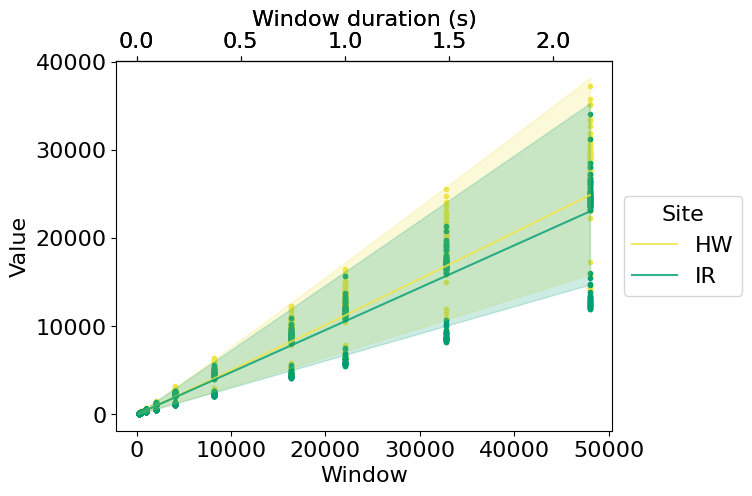

In [12]:
carara_broadband_ACI_fig


### Carara - broadband ADI


In [13]:
carara_broadband_ADI_fig, carara_broadband_ADI_ratio_summary = experiment(carara_df,
          broadband_ADI_group,
          carara_toolbox,
          r_link,
          marine=False,
          factors=['Site', 'Day'],
          cross_effect='Site')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Site * Window) + (1 | Day) 
   Data: data (Number of observations: 2860) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Day (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.08      0.04     0.03     0.19 1.00     4731     5671

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept         1.23      0.05     1.13     1.33 1.00     7750     5984
SiteIR           -0.01      0.05    -0.11     0.09 1.00    11901    14076
Window           -0.03      0.00    -0.04    -0.02 1.00    13637     9814
SiteIR:Window     0.01      0.01     0.00     0.02 1.00    11926    14119

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape    13.44      0.36    12.74    14.17 

In [14]:
print(carara_broadband_ADI_ratio_summary)


# A tibble: 1 × 2
   mean     sd
  <dbl>  <dbl>
1  1.06 0.0327



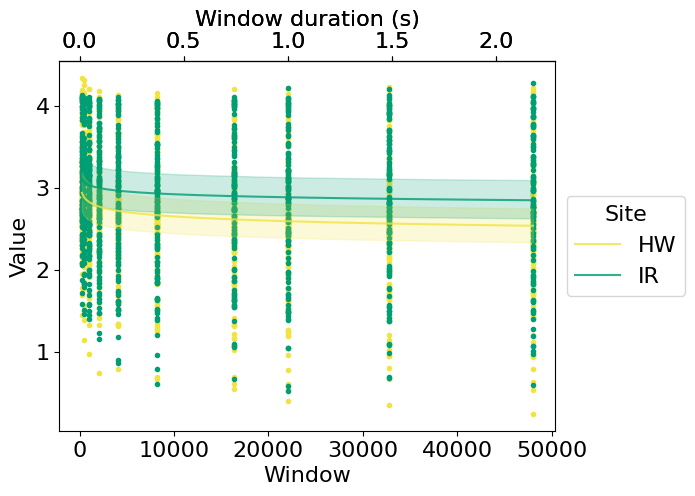

In [15]:
carara_broadband_ADI_fig


### Carara - broadband AEI


In [16]:
carara_broadband_AEI_fig, carara_broadband_AEI_ratio_summary = experiment(carara_df,
          broadband_AEI_group,
          carara_toolbox,
          r_link,
          marine=False,
          factors=['Site', 'Day'],
          cross_effect='Site')


 Family: beta 
  Links: mu = logit; phi = identity 
Formula: Value ~ (Site * Window) + (1 | Day) 
   Data: data (Number of observations: 2860) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Day (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.52      0.30     0.14     1.28 1.86        7       12

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept         1.78      0.10     1.64     2.02 1.60        8       28
SiteIR           -0.25      0.04    -0.32    -0.18 1.01      692     1880
Window            0.00      0.00     0.00     0.00 1.00     5511    12044
SiteIR:Window    -0.00      0.00    -0.00     0.00 1.00     2656     6236

Further Distributional Parameters:
    Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
phi    13.55      0.36    12.84    14.26 1.01 

In [17]:
print(carara_broadband_AEI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.01 0.00910



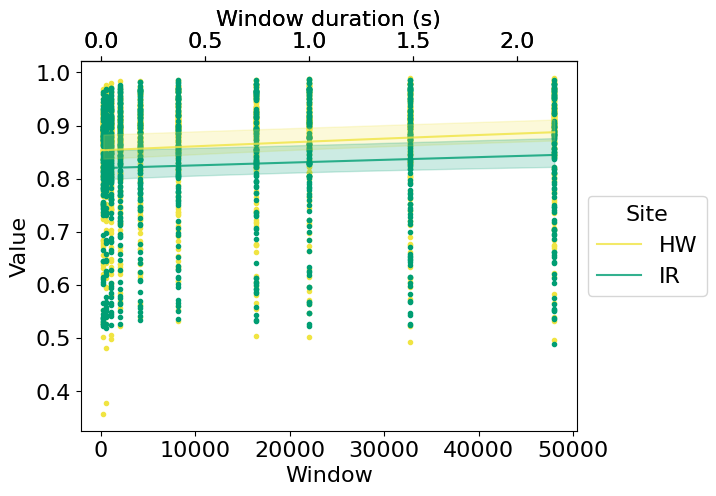

In [18]:
carara_broadband_AEI_fig


### Carara - broadband BIO


In [19]:
carara_broadband_BIO_fig, carara_broadband_BIO_ratio_summary = experiment(carara_df,
          broadband_BIO_group,
          carara_toolbox,
          r_link,
          marine=False,
          factors=['Site', 'Day'],
          cross_effect='Site')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Site * Window) + (1 | Day) 
   Data: data (Number of observations: 2860) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Day (Number of levels: 5) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.96      0.47     0.43     2.26 1.00     4925     7776

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -8.24      0.46    -9.17    -7.28 1.00     5181     5685
SiteIR           -0.31      0.07    -0.44    -0.18 1.00     9274    11495
Window            2.04      0.00     2.03     2.05 1.00    12776    15163
SiteIR:Window     0.01      0.01    -0.01     0.02 1.00     9197    11804

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape     8.42      0.22     8.00     8.85 

In [20]:
print(carara_broadband_BIO_ratio_summary)


# A tibble: 1 × 2
   mean     sd
  <dbl>  <dbl>
1  1.04 0.0314



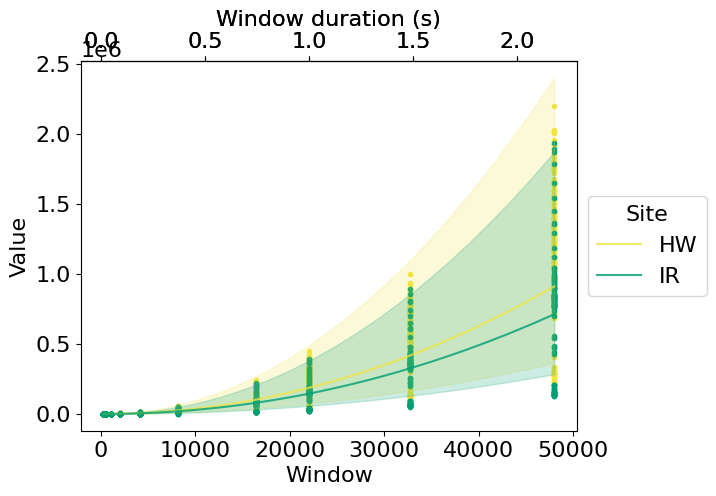

In [21]:
carara_broadband_BIO_fig


## Big Vicky

In [22]:
# settings and frequency bands
vicky_settings = BigVickySettings
vicky_settings.data_location = os.path.expanduser(vicky_settings.data_location)
test_bands = [("broadband", (100, vicky_settings.sample_rate), False),
              ("shrimp", vicky_settings.shrimp_frequencies, False),
              ("shrimp", vicky_settings.shrimp_frequencies, True),
              ("fish", vicky_settings.fish_frequencies, False),
              ("fish", vicky_settings.fish_frequencies, True)]


In [23]:
vicky_toolbox = BigVickyToolbox(vicky_settings, fft_window_sizes, test_bands, indices_of_interest)

In [24]:
vicky_index_values = vicky_toolbox.get_index_values(output_file="output/vicky_index_values.pkl")

In [25]:
vicky_df = vicky_toolbox.create_dataframe(vicky_index_values, output_path="output/vicky_dataframe.pkl")

### Big Vicky - broadband ACI


In [26]:
vicky_extracted_broadband_ACI_fig, vicky_extracted_broadband_ACI_ratio_summary = experiment(vicky_df,
          broadband_ACI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 5530) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.06      0.01     0.05     0.08 1.00     1923     3087

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept         0.35      0.01     0.32     0.37 1.00     1338     2108
Hour12           -0.09      0.01    -0.11    -0.08 1.00     6383     7863
Window            0.92      0.00     0.92     0.92 1.00     9459    12843
Hour12:Window     0.02      0.00     0.02     0.02 1.00     6497     8468

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape   416.80      7.98   401.46   432.

In [27]:
print(vicky_extracted_broadband_ACI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.10 0.00444



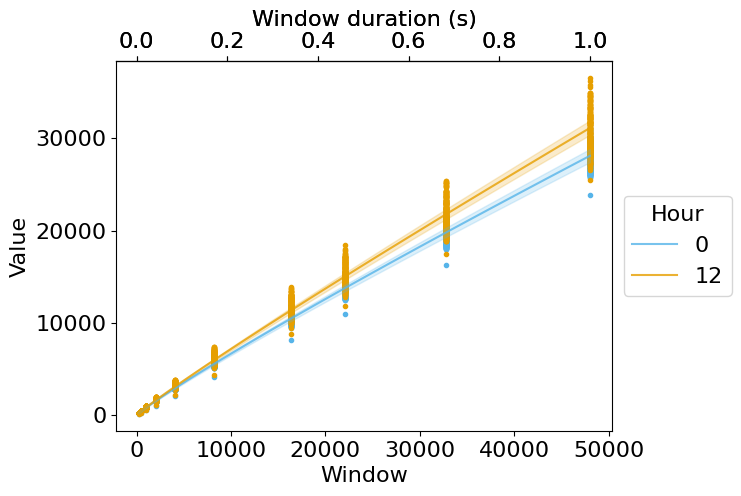

In [28]:
vicky_extracted_broadband_ACI_fig


### Big Vicky - extracted fish ACI


In [29]:
vicky_extracted_fish_ACI_fig, vicky_extracted_fish_ACI_ratio_summary = experiment(vicky_df,
          fish_extracted_ACI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 5530) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.05      0.01     0.04     0.06 1.00     2264     4021

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -3.64      0.01    -3.66    -3.61 1.00     2500     5192
Hour12           -0.17      0.01    -0.19    -0.14 1.00     7955    10721
Window            0.97      0.00     0.97     0.97 1.00    11414    15834
Hour12:Window     0.02      0.00     0.01     0.02 1.00     8007    10886

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape   147.38      2.80   142.05   152.

In [30]:
print(vicky_extracted_fish_ACI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.09 0.00754



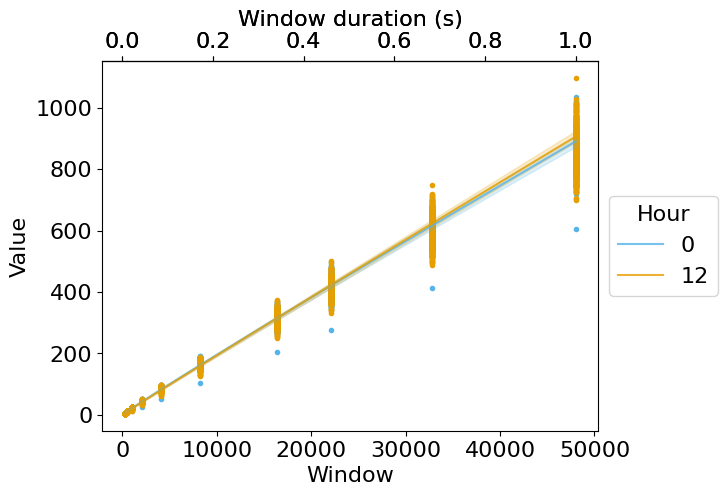

In [31]:
vicky_extracted_fish_ACI_fig


### Big Vicky - extracted shrimp ACI


In [32]:
vicky_extracted_shrimp_ACI_fig, vicky_extracted_shrimp_ACI_ratio_summary = experiment(vicky_df,
          shrimp_extracted_ACI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 5530) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.05      0.01     0.03     0.06 1.01     1642     3120

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -1.67      0.01    -1.69    -1.64 1.00     1916     3592
Hour12           -0.14      0.01    -0.16    -0.13 1.00     6661     9502
Window            0.92      0.00     0.91     0.92 1.00    10471    14285
Hour12:Window     0.03      0.00     0.02     0.03 1.00     6815     9890

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape   285.04      5.46   274.44   295.

In [33]:
print(vicky_extracted_shrimp_ACI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.15 0.00552



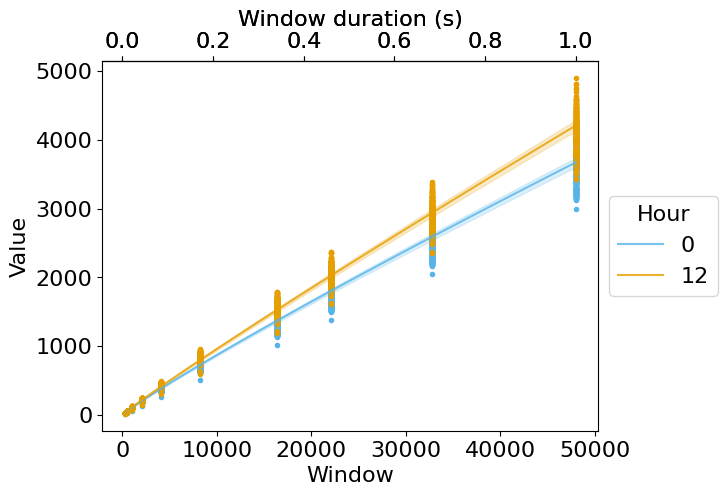

In [34]:
vicky_extracted_shrimp_ACI_fig


### Big Vicky - filtered fish ACI


In [35]:
vicky_filtered_fish_ACI_fig, vicky_filtered_fish_ACI_ratio_summary = experiment(vicky_df,
          fish_filtered_ACI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 5530) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.01      0.00     0.01     0.01 1.00     2572     3533

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -0.50      0.00    -0.51    -0.50 1.00     4323     8776
Hour12           -0.01      0.00    -0.01    -0.00 1.00    18264    16380
Window            0.99      0.00     0.99     0.99 1.00    21221    19579
Hour12:Window     0.00      0.00     0.00     0.00 1.00    18512    16434

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape  2275.70     43.27  2190.87  2361.

In [36]:
print(vicky_filtered_fish_ACI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.01 0.00173



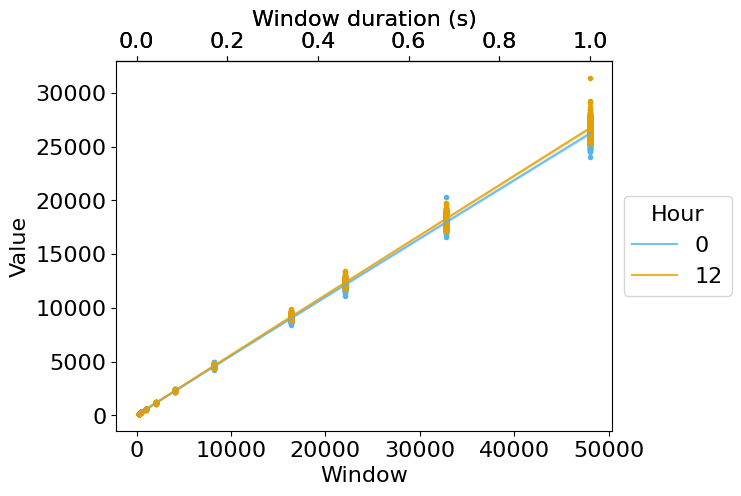

In [37]:
vicky_filtered_fish_ACI_fig


### Big Vicky - filtered shrimp ACI


In [38]:
vicky_filtered_shrimp_ACI_fig, vicky_filtered_shrimp_ACI_ratio_summary = experiment(vicky_df,
          shrimp_filtered_ACI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 5530) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.02      0.00     0.01     0.03 1.00     1699     3034

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -0.26      0.00    -0.27    -0.25 1.00     2211     4501
Hour12           -0.04      0.00    -0.05    -0.04 1.00     9931    13102
Window            0.97      0.00     0.97     0.97 1.00    13843    16638
Hour12:Window     0.01      0.00     0.01     0.01 1.00    10197    13279

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape  1489.04     28.73  1433.39  1546.

In [39]:
print(vicky_filtered_shrimp_ACI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.05 0.00224



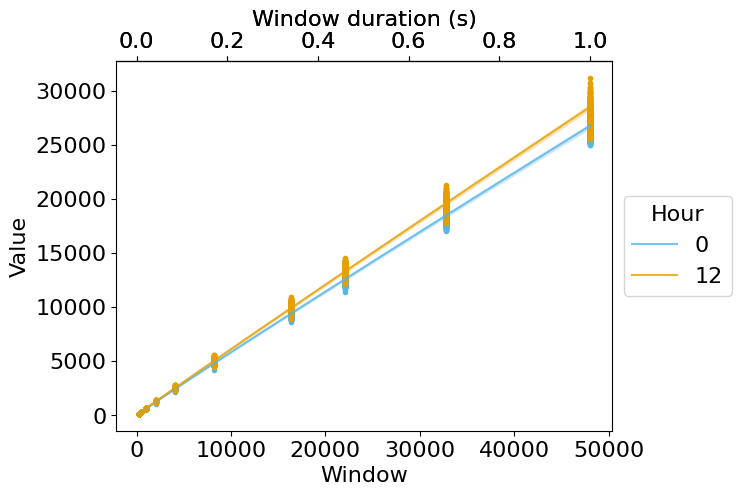

In [40]:
vicky_filtered_shrimp_ACI_fig


### Big Vicky - broadband ADI


In [41]:
vicky_extracted_broadband_ADI_fig, vicky_extracted_broadband_ADI_ratio_summary = experiment(vicky_df,
          broadband_ADI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 5530) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.02      0.00     0.02     0.03 1.00     2510     4276

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept         1.55      0.01     1.53     1.56 1.00     4075     8899
Hour12            0.10      0.01     0.09     0.12 1.00    15017    16237
Window            0.01      0.00     0.00     0.01 1.00    18490    20217
Hour12:Window    -0.01      0.00    -0.01    -0.01 1.00    15049    16397

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape   337.74      6.42   325.35   350.

In [42]:
print(vicky_extracted_broadband_ADI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.07 0.00474



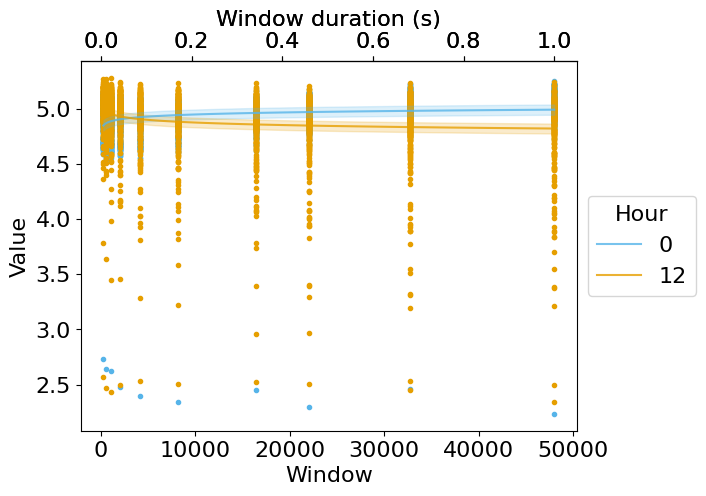

In [43]:
vicky_extracted_broadband_ADI_fig


### Big Vicky - extracted fish ADI


In [44]:
vicky_extracted_fish_ADI_fig, vicky_extracted_fish_ADI_ratio_summary = experiment(vicky_df,
          fish_extracted_ADI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 5530) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.03      0.01     0.02     0.04 1.00     3660     5541

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -0.06      0.01    -0.08    -0.03 1.00     6176    11167
Hour12            0.02      0.01    -0.01     0.04 1.00    12526    15383
Window            0.05      0.00     0.05     0.05 1.00    16032    18832
Hour12:Window    -0.01      0.00    -0.01    -0.00 1.00    12440    15072

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape   104.37      2.00   100.49   108.

In [45]:
print(vicky_extracted_fish_ADI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.04 0.00842



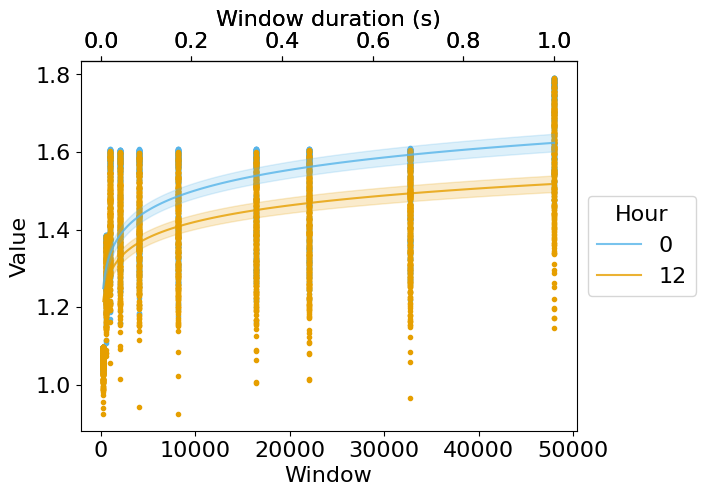

In [46]:
vicky_extracted_fish_ADI_fig


### Big Vicky - extracted shrimp ADI


In [47]:
vicky_extracted_shrimp_ADI_fig, vicky_extracted_shrimp_ADI_ratio_summary = experiment(vicky_df,
          shrimp_extracted_ADI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 5530) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.00      0.00     0.00     0.00 1.00     5882     7583

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept         1.18      0.00     1.18     1.18 1.00    17781    19739
Hour12            0.01      0.00     0.00     0.01 1.00    42055    17091
Window            0.00      0.00     0.00     0.00 1.00    31070    19834
Hour12:Window    -0.00      0.00    -0.00    -0.00 1.00    41104    17034

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape  5483.58    104.27  5281.04  5690.

In [48]:
print(vicky_extracted_shrimp_ADI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.01 0.00112



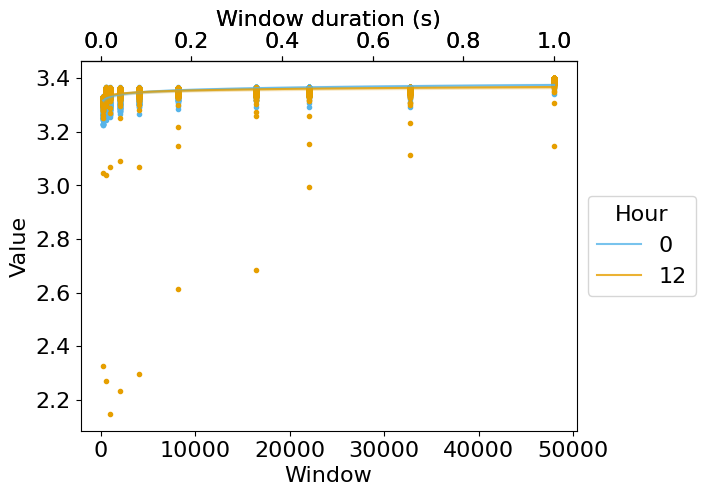

In [49]:
vicky_extracted_shrimp_ADI_fig


### Big Vicky - filtered fish ADI


In [50]:
vicky_filtered_fish_ADI_fig, vicky_filtered_fish_ADI_ratio_summary = experiment(vicky_df,
          fish_filtered_ADI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 5530) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.03      0.00     0.02     0.04 1.00     2424     3494

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept         0.75      0.01     0.73     0.77 1.00     2285     4008
Hour12           -0.07      0.01    -0.08    -0.06 1.00    11115    13188
Window           -0.01      0.00    -0.01    -0.01 1.00    14629    17060
Hour12:Window    -0.00      0.00    -0.01    -0.00 1.00    11210    13500

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape   380.15      7.24   366.05   394.

In [51]:
print(vicky_filtered_fish_ADI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.02 0.00421



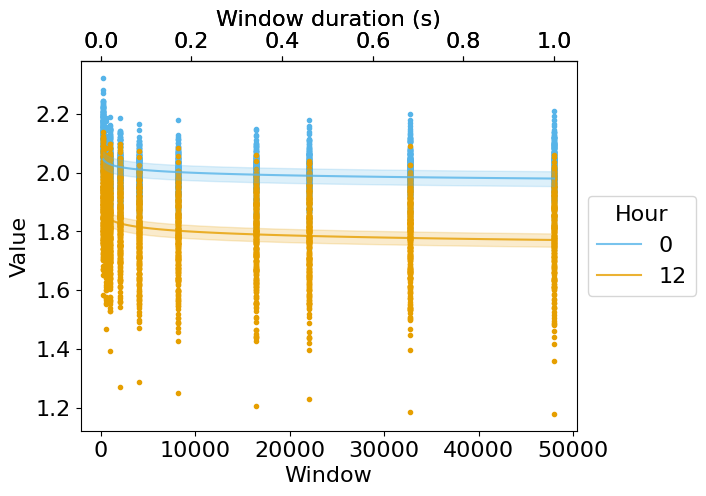

In [52]:
vicky_filtered_fish_ADI_fig


### Big Vicky - filtered shrimp ADI


In [53]:
vicky_filtered_shrimp_ADI_fig, vicky_filtered_shrimp_ADI_ratio_summary = experiment(vicky_df,
          shrimp_filtered_ADI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 5530) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.01      0.00     0.00     0.01 1.00     2726     4930

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept         1.24      0.00     1.24     1.24 1.00     3652     8567
Hour12            0.03      0.00     0.02     0.03 1.00    17629    17220
Window            0.00      0.00     0.00     0.00 1.00    20762    19360
Hour12:Window    -0.00      0.00    -0.00    -0.00 1.00    17833    16958

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape  4517.37     86.79  4345.55  4688.

In [54]:
print(vicky_filtered_shrimp_ADI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.02 0.00123



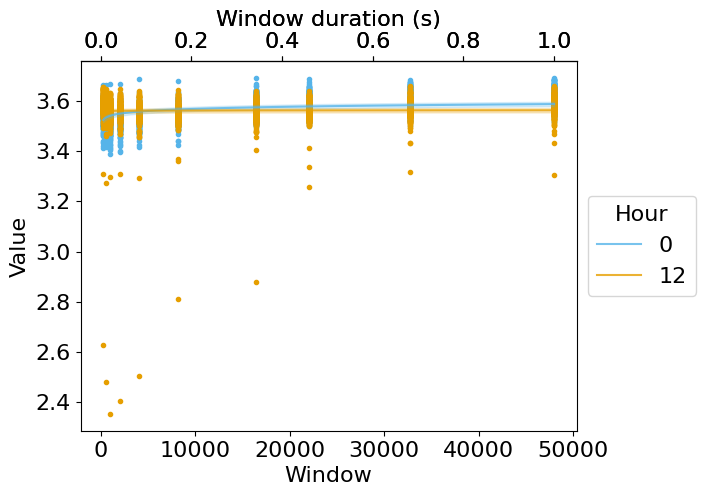

In [55]:
vicky_filtered_shrimp_ADI_fig


### Big Vicky - broadband AEI


In [56]:
vicky_extracted_broadband_AEI_fig, vicky_extracted_broadband_AEI_ratio_summary = experiment(vicky_df,
          broadband_AEI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: beta 
  Links: mu = logit; phi = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 5530) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     1.14      0.11     1.01     1.36 3.02        6       11

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept         0.25      0.02     0.21     0.29 2.15        6       14
Hour12           -0.17      0.01    -0.19    -0.15 1.01      711     1334
Window           -0.00      0.00    -0.00    -0.00 1.00     2755     7558
Hour12:Window     0.00      0.00     0.00     0.00 1.00     1503     4563

Further Distributional Parameters:
    Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
phi    54.73      1.48    51.03    57.15 1.

In [57]:
print(vicky_extracted_broadband_AEI_ratio_summary)


# A tibble: 1 × 2
   mean     sd
  <dbl>  <dbl>
1  1.33 0.0152



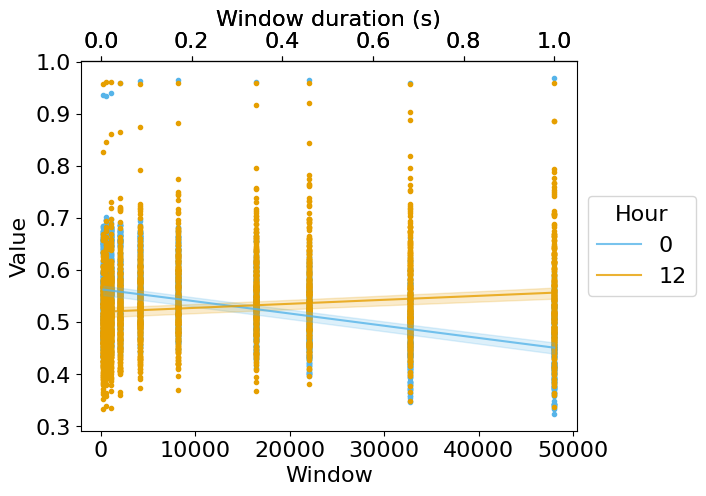

In [58]:
vicky_extracted_broadband_AEI_fig


### Big Vicky - extracted fish AEI


In [59]:
vicky_extracted_fish_AEI_fig, vicky_extracted_fish_AEI_ratio_summary = experiment(vicky_df,
          fish_extracted_AEI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: beta 
  Links: mu = logit; phi = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 5530) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.92      0.17     0.66     1.29 1.64        8       30

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -1.40      0.04    -1.49    -1.35 1.51        9       24
Hour12            0.40      0.02     0.36     0.45 1.01      491      966
Window            0.00      0.00     0.00     0.00 1.00     2536     8078
Hour12:Window     0.00      0.00     0.00     0.00 1.00     1324     4315

Further Distributional Parameters:
    Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
phi    11.68      0.21    11.27    12.10 1.

In [60]:
print(vicky_extracted_fish_AEI_ratio_summary)


# A tibble: 1 × 2
   mean     sd
  <dbl>  <dbl>
1  1.09 0.0406



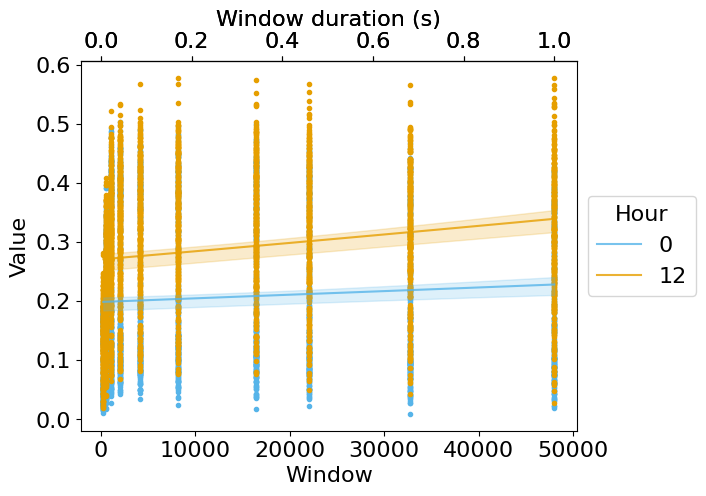

In [61]:
vicky_extracted_fish_AEI_fig


### Big Vicky - extracted shrimp AEI


In [62]:
vicky_extracted_shrimp_AEI_fig, vicky_extracted_shrimp_AEI_ratio_summary = experiment(vicky_df,
          shrimp_extracted_AEI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: beta 
  Links: mu = logit; phi = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 5530) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     1.20      0.24     0.92     1.96 1.99        7       11

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -2.03      0.04    -2.11    -1.97 2.46        6       25
Hour12           -0.17      0.01    -0.19    -0.14 1.02      373      691
Window           -0.00      0.00    -0.00    -0.00 1.01     1693     6616
Hour12:Window     0.00      0.00     0.00     0.00 1.01      956     2425

Further Distributional Parameters:
    Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
phi    76.97      1.51    74.02    80.00 1.

In [63]:
print(vicky_extracted_shrimp_AEI_ratio_summary)


# A tibble: 1 × 2
   mean     sd
  <dbl>  <dbl>
1  1.99 0.0682



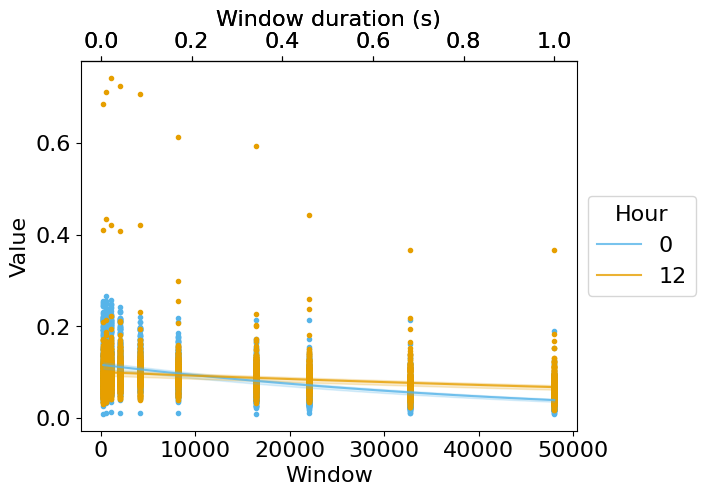

In [64]:
vicky_extracted_shrimp_AEI_fig


### Big Vicky - filtered fish AEI


In [65]:
vicky_filtered_fish_AEI_fig, vicky_filtered_fish_AEI_ratio_summary = experiment(vicky_df,
          fish_filtered_AEI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: beta 
  Links: mu = logit; phi = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 5530) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     1.00      0.01     0.99     1.02 3.25        6       30

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept         3.64      0.00     3.63     3.64 1.30       13       93
Hour12            0.20      0.00     0.20     0.21 1.02      270      659
Window            0.00      0.00    -0.00     0.00 1.00     1523     4411
Hour12:Window     0.00      0.00     0.00     0.00 1.00      684     2079

Further Distributional Parameters:
    Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
phi  3585.69    111.46  3353.22  3802.24 1.

In [66]:
print(vicky_filtered_fish_AEI_ratio_summary)


# A tibble: 1 × 2
   mean       sd
  <dbl>    <dbl>
1  1.00 0.000218



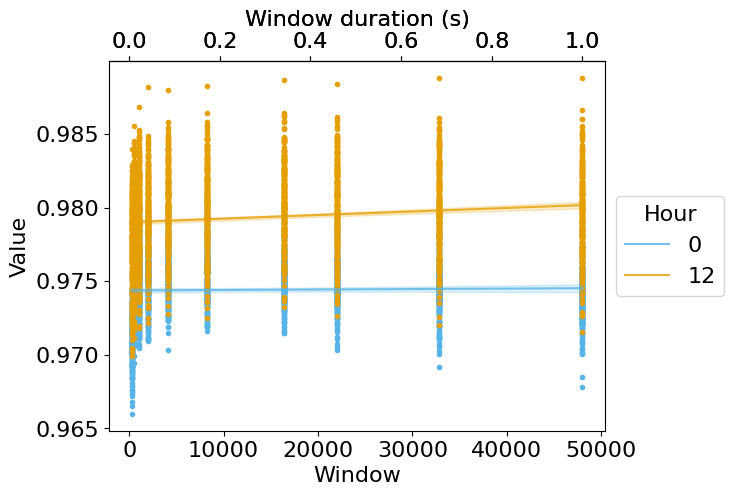

In [67]:
vicky_filtered_fish_AEI_fig


### Big Vicky - filtered shrimp AEI


In [68]:
vicky_filtered_shrimp_AEI_fig, vicky_filtered_shrimp_AEI_ratio_summary = experiment(vicky_df,
          shrimp_filtered_AEI_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: beta 
  Links: mu = logit; phi = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 5530) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.99      0.01     0.98     1.01 3.57        5       18

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept         1.97      0.00     1.96     1.98 1.82        7       24
Hour12           -0.03      0.01    -0.03    -0.01 1.93        7       18
Window           -0.00      0.00    -0.00    -0.00 1.37       11       43
Hour12:Window     0.00      0.00     0.00     0.00 1.57        9       40

Further Distributional Parameters:
    Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
phi  2086.30     67.00  1965.71  2206.14 2.

In [69]:
print(vicky_filtered_shrimp_AEI_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.01 0.00124



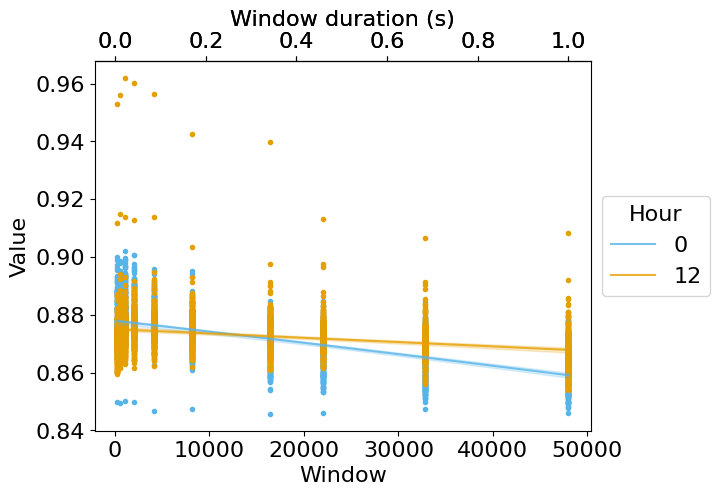

In [70]:
vicky_filtered_shrimp_AEI_fig


### Big Vicky - broadband BIO


In [71]:
vicky_extracted_broadband_BIO_fig, vicky_extracted_broadband_BIO_ratio_summary = experiment(vicky_df,
          broadband_BIO_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 5530) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.15      0.02     0.11     0.20 1.00     1492     1791

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -8.37      0.03    -8.43    -8.31 1.00     1473     1931
Hour12            0.01      0.01    -0.01     0.03 1.00     5491     6952
Window            2.03      0.00     2.03     2.03 1.00     6882    10147
Hour12:Window    -0.02      0.00    -0.02    -0.02 1.00     5562     7233

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape   129.89      2.45   125.11   134.

In [72]:
print(vicky_extracted_broadband_BIO_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.10 0.00783



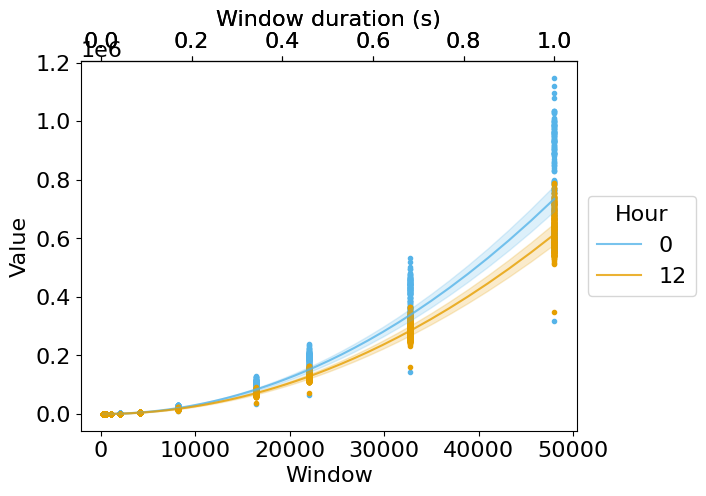

In [73]:
vicky_extracted_broadband_BIO_fig


### Big Vicky - extracted fish BIO


In [74]:
vicky_extracted_fish_BIO_fig, vicky_extracted_fish_BIO_ratio_summary = experiment(vicky_df,
          fish_extracted_BIO_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 5530) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.31      0.05     0.23     0.43 1.00     2029     4432

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept       -14.56      0.08   -14.72   -14.41 1.00     2406     4123
Hour12            0.25      0.06     0.14     0.37 1.00     5753     8006
Window            2.17      0.01     2.16     2.18 1.00     6749     9975
Hour12:Window    -0.05      0.01    -0.06    -0.03 1.00     5720     8011

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape     5.56      0.10     5.36     5.

In [75]:
print(vicky_extracted_fish_BIO_ratio_summary)


# A tibble: 1 × 2
   mean     sd
  <dbl>  <dbl>
1  1.27 0.0461



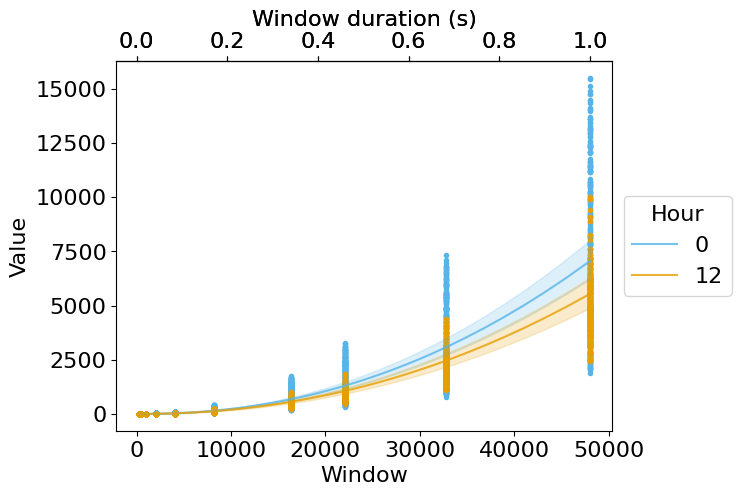

In [76]:
vicky_extracted_fish_BIO_fig


### Big Vicky - extracted shrimp BIO


In [77]:
vicky_extracted_shrimp_BIO_fig, vicky_extracted_shrimp_BIO_ratio_summary = experiment(vicky_df,
          shrimp_extracted_BIO_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 5530) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.23      0.04     0.17     0.31 1.00     1756     4118

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept       -13.00      0.05   -13.09   -12.90 1.00     1638     2663
Hour12            0.07      0.02     0.02     0.11 1.00     5297     6796
Window            2.09      0.00     2.08     2.09 1.00     6250     8722
Hour12:Window     0.01      0.00     0.00     0.01 1.00     5297     6928

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape    29.19      0.55    28.11    30.

In [78]:
print(vicky_extracted_shrimp_BIO_ratio_summary)


# A tibble: 1 × 2
   mean     sd
  <dbl>  <dbl>
1  1.03 0.0149



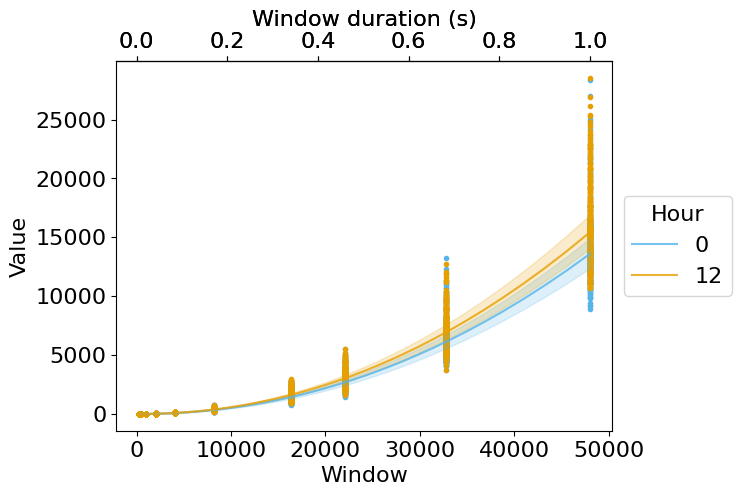

In [79]:
vicky_extracted_shrimp_BIO_fig


### Big Vicky - filtered fish BIO


In [80]:
vicky_filtered_fish_BIO_fig, vicky_filtered_fish_BIO_ratio_summary = experiment(vicky_df,
          fish_filtered_BIO_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 5530) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.02      0.00     0.02     0.03 1.00     1550     2530

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -9.14      0.01    -9.15    -9.13 1.01     1531     3442
Hour12            0.01      0.00     0.01     0.02 1.00     8816    12641
Window            2.07      0.00     2.06     2.07 1.00    12655    17362
Hour12:Window    -0.01      0.00    -0.01    -0.01 1.00     9146    12533

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape  1385.21     26.31  1333.93  1437.

In [81]:
print(vicky_filtered_fish_BIO_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.06 0.00230



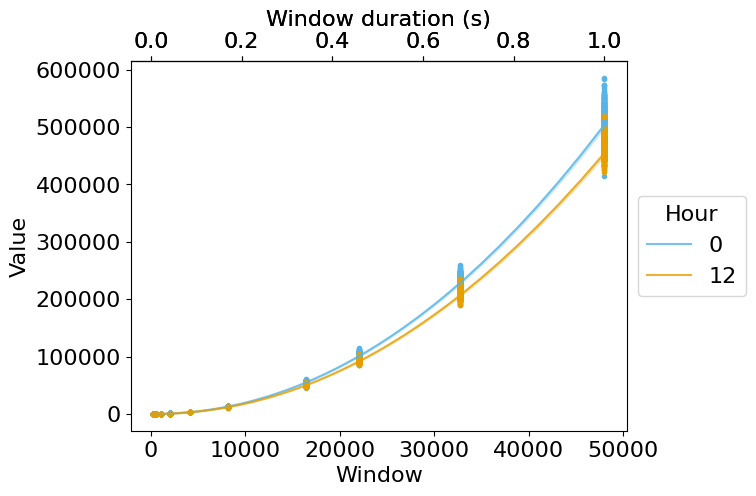

In [82]:
vicky_filtered_fish_BIO_fig


### Big Vicky - filtered shrimp BIO


In [83]:
vicky_filtered_shrimp_BIO_fig, vicky_filtered_shrimp_BIO_ratio_summary = experiment(vicky_df,
          shrimp_filtered_BIO_group,
          vicky_toolbox,
          r_link,
          marine=True,
          factors=['Hour', 'Site'],
          cross_effect='Hour')


 Family: gamma 
  Links: mu = log; shape = identity 
Formula: Value ~ (Hour * Window) + (1 | Site) 
   Data: data (Number of observations: 5530) 
  Draws: 5 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 25000

Multilevel Hyperparameters:
~Site (Number of levels: 25) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.02      0.00     0.01     0.02 1.00     1870     3900

Regression Coefficients:
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept        -8.68      0.00    -8.68    -8.67 1.00     2445     5622
Hour12           -0.01      0.00    -0.01     0.00 1.00    10488    13840
Window            2.10      0.00     2.10     2.10 1.00    14852    17516
Hour12:Window     0.00      0.00     0.00     0.00 1.00    10653    14420

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
shape  1050.22     20.08  1011.56  1090.

In [84]:
print(vicky_filtered_shrimp_BIO_ratio_summary)


# A tibble: 1 × 2
   mean      sd
  <dbl>   <dbl>
1  1.02 0.00256



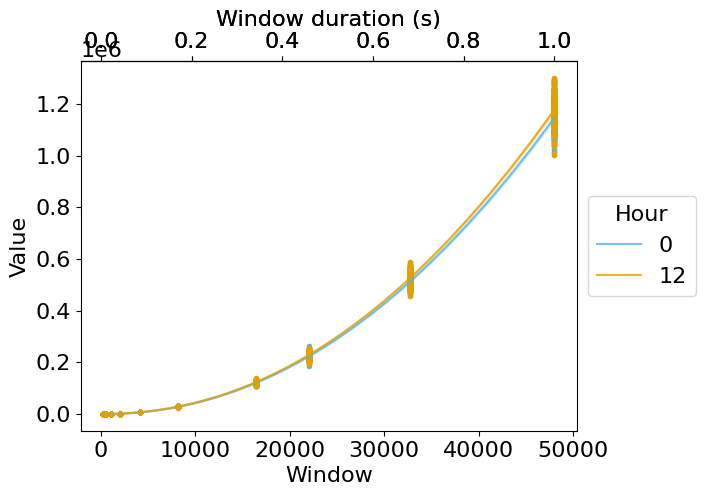

In [85]:
vicky_filtered_shrimp_BIO_fig
